In [1]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import numba
import seaborn as sns
sns.set(
    style='ticks',
    font_scale=1.5
)
from tqdm import tqdm_notebook as tqdm
import sys
sys.path.append('../src')
import plots

In [2]:
import scipy.stats

In [4]:
def simulation(N, n, η, ω, π0):
    """Run a single simulation.
    
    Parameters
    ----------
    N : int
        constant population size
    n : int
        number of generations
    η : float
        learning rate, 0 <= η <= 1    
    ω : numpy.ndarray
        fitness values for the two phenotyes: ω[t, i] >= 0 fitness of phenotype i at time t
    π0 : function
        function that given N, returns an initial value for π.    

    Returns
    -------
    π : np.ndarray
        π[t, i] is the probability for phenotype 0 in individual i at time t
    """        
    # π[t, i] is the probability for phenotype 0 atin individual i at time t
    π = np.zeros((n, N), dtype=float)
    π[0, :] = π0(N)
    π[0, π[0, :] < 0] = 0
    π[0, π[0, :] > 1] = 1
    π[1, :] = π[0, :] # for light simulations

    for t in range(n - 1):
        # phenotype of each individual
        φ = np.zeros(N, dtype=int)
        φ[np.random.random(N) > π[t, :]] = 1
        # fitness of each invidividual in current environment
        ω_t = ω[t, φ]
        assert (ω_t > 0).any(), "Population extinct, ω_t=0"
        ω_t = ω_t / ω_t.sum()
        # selection & reproduction; idx is the indexes of reproducing individuals
        idx = np.random.choice(N, N, True, ω_t)
        # offspring phenotype probability
        π_ = π[t, idx]
        π_ = (1 - η) * π_ + η * (φ[idx] == 0) # learning
        assert (π_ <= 1).all(), π_[π_ > 1]
        assert (π_ >= 0).all(), π_[π_ < 0]
        π[t + 1, :] = π_
    return π

In [15]:
N = 100000
n = 1000
η = 0.1
p = 0.495
s = 0.1

s = np.random.choice([s, -s], size=n, replace=True, p=[p, 1-p])
ωA = 1 + s 
ωB = np.ones(n)
print((ωA - ωB).mean(), np.log(1 + η * s).mean())
ω = np.array([ωA, ωB]).T

5.57331958362e-17 -5.00025001667e-05


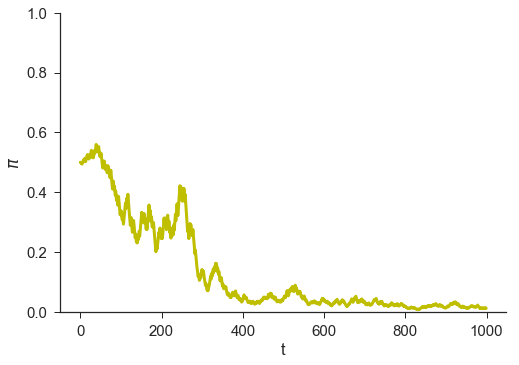

In [17]:
π_fix = simulation(N, n, η, ω, lambda N: np.ones(N) * 0.5)
plots.plot_π(π, bands=0)

In [19]:
np.log(1.01)

0.009950330853168092

In [18]:
π[-1, :].mean()

0.011209999999999998

In [ ]:
N = 100000
n = 1000
η = 0.1
p = 0.5
s = 0.1

reps = 100
results = []
for _ in range(reps):
    s_ = np.random.choice([s, -s], size=n, replace=True, p=[p, 1-p])
    ωA = 1 + s_ 
    ωB = np.ones(n)
    E = (ωA - ωB).mean()
    Elog =  np.log(1 + η * s_).mean()
    ω = np.array([ωA, ωB]).T
    π = simulation(N, n, η, ω, lambda N: np.ones(N) * 0.5)
    π_ = π[-1, :].mean()
    results.append(dict(π=π_, E=E, Elog=Elog, ))
df = pd.DataFrame(results)

In [148]:
df['E2'] = np.exp(df['Elog']-1)

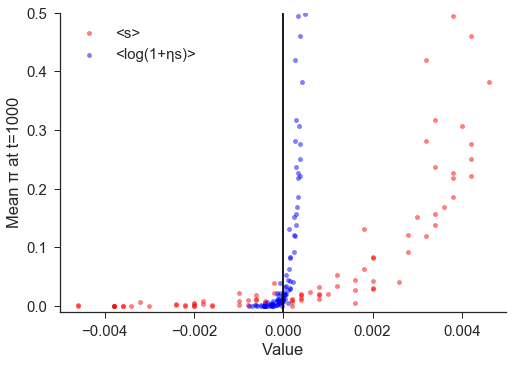

In [167]:
fig, ax = plt.subplots(1, 1)
df.plot('E', 'π', kind='scatter', color='r', alpha=0.5, label='<s>', ax=ax)
df.plot('Elog', 'π', kind='scatter', color='b', alpha=0.5, label='<log(1+ηs)>', ax=ax)
ax.axvline(0, color='k')
ax.legend(loc='upper left')
ax.set(
    xlabel='Value',
    ylabel='Mean π at t={}'.format(n),
    xlim=(-0.005, 0.005),
    ylim=(-0.01, 0.5)
)
sns.despine()

In [ ]:
N = 100000
n = 1000
η = 0.1

reps = 100
results = []
for _ in range(reps):
    p = 0.5 + -1**(np.random.randint(0,2)) * np.random.random()/10
    s = np.random.random()/10
    s_ = np.random.choice([s, -s], size=n, replace=True, p=[p, 1-p])
    ωA = 1 + s_ 
    ωB = np.ones(n)
    E = (ωA - ωB).mean()
    Elog =  np.log(1 + η * s_).mean()
    ω = np.array([ωA, ωB]).T
    π = simulation(N, n, η, ω, lambda N: np.ones(N) * 0.5)
    π_ = π[-1, :].mean()
    print('p={:.2g}, s={:.2g}, E={:.2g}, Elog={:.2g}'.format(p, s, E, Elog))
    results.append(dict(N=N, p=p, s=s, π=π_, η=η, E=E, Elog=Elog))
df = pd.DataFrame(results)

# Recurrence

-4.0842194815e-05 3.04009859604e-20


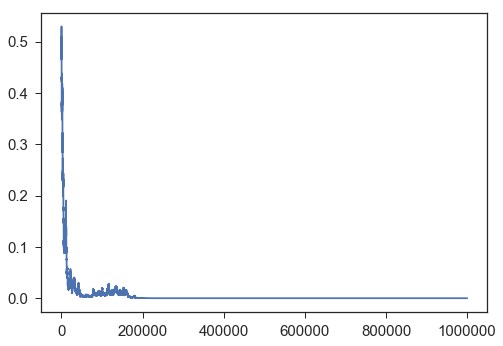

In [2]:
@numba.jit()
def recurrence(x0, n, η, s, p):
    x = np.empty(n)
    x[0] = x0
    s_ = np.random.choice([s, -s], size=n, replace=True, p=[p, 1-p])    
    for t in range(1, n):
        x[t] = x[t-1] * (1 + η * s_[t-1] + x[t-1] * (1 - η) * s_[t-1]) / (1 + s_[t-1] * x[t-1])
    return x, np.log(1 + η * s_).mean()

x, _ = recurrence(0.5, 1000000, 0.1, 0.1, 0.5)
print(_, x[-1])
plt.plot(x);

In [3]:
n = 1000000
η = 0.1
x0 = 0.1

p = np.linspace(0.48, 0.52, 100)
s = np.linspace(0.01, 0.1, 100)
x = np.empty((p.size, s.size))
Elog = np.empty((p.size, s.size))
Elog_d = np.empty((p.size, s.size))

In [4]:
for i, p_ in enumerate(tqdm(p, desc='p')):
    for j, s_ in enumerate(s):
        x_, Elog_ = recurrence(x0=x0, n=n, η=η, s=s_, p=p_)
        x[i, j] = x_[-1]
        Elog[i, j] = Elog_
        Elog_d[i, j] = p_ * np.log(1 + η * s_) + (1 - p_) * np.log(1 - η * s_)
#         print('x={:.2g}, p={:.2g}, s={:.2g}, Elog={:.2g}'.format(x_[-1], p_, s_, Elog_d[i,j]))

In [5]:
with open('rand_env_sim_cache.pkl', 'wb') as f:
    pickle.dump(dict(x=x, Elog=Elog, Elog_d=Elog_d), f)

In [7]:
with open('rand_env_sim_cache.pkl', 'rb') as f:
    d = pickle.load(f)
    x = d['x']
    Elog = d['Elog']
    Elog_d = d['Elog_d']

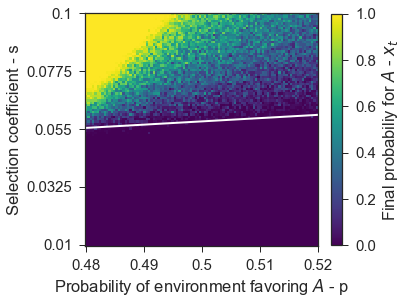

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
extent = (-0.5, x.shape[0], -0.5, x.shape[1])

# ax = axes[0]
im1 = ax.imshow(x, aspect=1, origin=(0, 0), cmap='viridis', vmin=0, vmax=1, extent=extent)
cntr = ax.contour(Elog_d, levels=[0], aspect=1, linewidths=2, colors='w', extent=extent)
cb1 = plt.colorbar(im1, ax=ax, fraction=0.045, label='Final probabiliy for $A$ - $x_t$')
ax.set(
    xlabel='Probability of environment favoring $A$ - p',
    ylabel='Selection coefficient - s',
    xticks=np.linspace(0, p.size, 5),
    yticks=np.linspace(0, s.size, 5),
    xticklabels=np.linspace(p[0], p[-1], 5),
    yticklabels=np.linspace(s[0], s[-1], 5)
)

# ax = axes[1]
# im2 = ax.imshow(Elog, aspect=1, origin=(0, 0), cmap='RdYlBu', interpolation='none', extent=extent)
# cntr = ax.contour(Elog, levels=[-0.0001, 0, 0.0001], aspect=1, linewidths=0.5, colors='k', interpolation='none', extent=extent)
# ax.clabel(cntr, fmt=lambda x: '{:.3g}'.format(x),fontsize=16, colors="#252525")
# cb2 = plt.colorbar(im2, ax=ax, fraction=0.045, label=r'$E[log(1+\eta s_t)]$'.format(n))
# ax.set(
#     xlabel='p',
#     ylabel='s',
#     xticks=np.linspace(0, p.size, 5),
#     yticks=np.linspace(0, s.size, 5),
#     xticklabels=np.linspace(p[0], p[-1], 5),
#     yticklabels=np.linspace(s[0], s[-1], 5)
# )
fig.tight_layout()
fig.savefig('../figures/stochastic_env_x_t.pdf', bbox_inches='tight')